### Option 2 : K-means
#### Iris Dataset
The Iris data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Download here: https://archive.ics.uci.edu/ml/datasets/iris

##### To Do
1.	Import the Iris dataset.
2.	Build a K-means model to classify the species of Iris. You can choose a k value randomly at this step.
3.	Report the original performance using Silhouette score. 
4.	Try to improve the performance of the original model by trying at least 10 different k values.
5.	Select the best k based on step 4 and print out the following sentence in your code:
“k=xx gives the best performance, Silhouette =xx "
(replace xx with your own numbers)

In [1]:
#Mounting Google Drive for access to directories on Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Spark

/content/drive/MyDrive/Spark


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [6]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/Spark/spark-3.0.0-bin-hadoop3.2"

In [8]:
import findspark
findspark.init()

In [9]:
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

In [12]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### 1. Importing Iris Dataset

In [29]:
#Importing needeed libraries
import pandas as pd
import pyspark
from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import csv

from sklearn.datasets import load_iris

In [18]:
#Load Iris Dataset
iris = load_iris(as_frame=True)
iris

{'data':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 columns], 'target': 0      

In [19]:
#Converting to Pandas Dataframe
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
#iris_df['target'] = pd.Series(df_iris.target)

In [20]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [21]:
# We can see above dataframe doesn't contain the target/class details, hence adding it temporarily (however we'll wont need target for clustering model)
iris_df['target'] = pd.Series(iris.target)

In [24]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [26]:
# Now we'll convert the above dataframe to spark dataframe and drop the target column since we won't need it for modelling
iris_dfs = spark.createDataFrame(iris_df)
iris_dfs = iris_dfs.drop("target")
iris_dfs.show()

+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
|              4.6|             3.4|              1.4|             0.3|
|              5.0|             3.4|              1.5|             0.2|
|              4.4|             2.9|              1.4|             0.2|
|              4.9|             3.1|              1.5|             0.1|
|              5.4|             3.7|              1.5|          

### 2.	Build a K-means model to classify the species of Iris. You can choose a k value randomly at this step

In [30]:
#Now, creating a vector assembler to prepare for medelling.
vec = VectorAssembler(inputCols=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)'], outputCol = 'iris_vectors') #generates a vector output column with the given inputcols 
asmbl_df=vec.transform(iris_dfs) 
asmbl_df.show()

+-----------------+----------------+-----------------+----------------+-----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|     iris_vectors|
+-----------------+----------------+-----------------+----------------+-----------------+
|              5.1|             3.5|              1.4|             0.2|[5.1,3.5,1.4,0.2]|
|              4.9|             3.0|              1.4|             0.2|[4.9,3.0,1.4,0.2]|
|              4.7|             3.2|              1.3|             0.2|[4.7,3.2,1.3,0.2]|
|              4.6|             3.1|              1.5|             0.2|[4.6,3.1,1.5,0.2]|
|              5.0|             3.6|              1.4|             0.2|[5.0,3.6,1.4,0.2]|
|              5.4|             3.9|              1.7|             0.4|[5.4,3.9,1.7,0.4]|
|              4.6|             3.4|              1.4|             0.3|[4.6,3.4,1.4,0.3]|
|              5.0|             3.4|              1.5|             0.2|[5.0,3.4,1.5,0.2]|
|         

In [35]:
# Fitting a k-means model (k=3) #since we already know there are 3 species (setosa, virginica and versicolor)
k_means = KMeans(featuresCol='iris_vectors', k=3) 
k_model=k_means.fit(asmbl_df)

# Predicting and displaying clusters 
kmeans_pred=k_model.transform(asmbl_df)
kmeans_pred.show()

+-----------------+----------------+-----------------+----------------+-----------------+----------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|     iris_vectors|prediction|
+-----------------+----------------+-----------------+----------------+-----------------+----------+
|              5.1|             3.5|              1.4|             0.2|[5.1,3.5,1.4,0.2]|         0|
|              4.9|             3.0|              1.4|             0.2|[4.9,3.0,1.4,0.2]|         0|
|              4.7|             3.2|              1.3|             0.2|[4.7,3.2,1.3,0.2]|         0|
|              4.6|             3.1|              1.5|             0.2|[4.6,3.1,1.5,0.2]|         0|
|              5.0|             3.6|              1.4|             0.2|[5.0,3.6,1.4,0.2]|         0|
|              5.4|             3.9|              1.7|             0.4|[5.4,3.9,1.7,0.4]|         0|
|              4.6|             3.4|              1.4|             0.3|[4.6,3.4,1.4,0.3]|  

### 3. Report the original performance using Silhouette score. 

In [39]:
# Using Silhouette score to evaluate clusters
evaluator = ClusteringEvaluator(featuresCol='iris_vectors')

s_score = evaluator.evaluate(kmeans_pred)
print("Silhouette Score of (k=3) is :" + str(s_score))

Silhouette Score of (k=3) is :0.7344130579787836


### 4.	Try to improve the performance of the original model by trying at least 10 different k values.

In [40]:
max_s_score = 0
best_k = 0 

for k in range(2,12):
    # Fitting model for different k values
    k_means = KMeans(featuresCol='iris_vectors', k=k)
    k_model = k_means.fit(asmbl_df)
    k_pred = k_model.transform(asmbl_df) 

    # Getting the silhouette score to evaluate clusters
    s_score = evaluator.evaluate(k_pred)
    print("For (k="+ str(k) + "), the obtained Silhouette Score is :" + str(s_score))

    # storing the k and s_score for max score (best k and sil score)
    if s_score > max_s_score:
      max_s_score = s_score
      best_k = k

For (k=2), the obtained Silhouette Score is :0.8503512229251465
For (k=3), the obtained Silhouette Score is :0.7344130579787836
For (k=4), the obtained Silhouette Score is :0.678799860932182
For (k=5), the obtained Silhouette Score is :0.671113643229135
For (k=6), the obtained Silhouette Score is :0.5063045990351738
For (k=7), the obtained Silhouette Score is :0.5250277068566052
For (k=8), the obtained Silhouette Score is :0.5831358542277786
For (k=9), the obtained Silhouette Score is :0.5569456705842679
For (k=10), the obtained Silhouette Score is :0.4682938429532273
For (k=11), the obtained Silhouette Score is :0.48612183879529974


### 5.	Select the best k based on step 4 and print out the following sentence in your code: “k=xx gives the best performance, Silhouette =xx " (replace xx with your own numbers)


In [41]:
# we have stored our best k value in 'best_k' and the respective silhouette score in 'max_s_score'
print("k="+ str(best_k) + " gives the best performance, Silhouette = "+ str(max_s_score))

k=2 gives the best performance, Silhouette = 0.8503512229251465


### Additional analysis on silhouette score and plot


For (k= 2 ) the silhouette score is : 0.6810461692117462
Silhouette Plot:


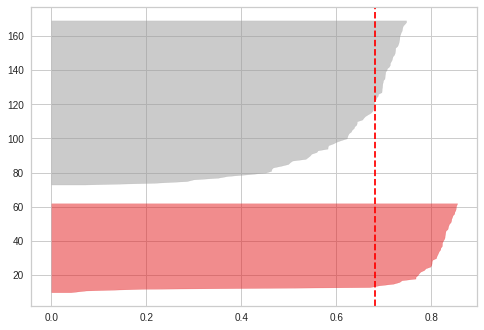

For (k= 3 ) the silhouette score is : 0.5528190123564095
Silhouette Plot:


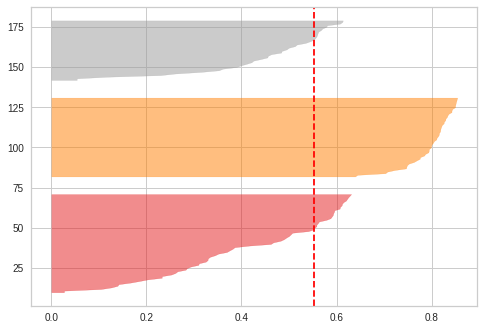

For (k= 4 ) the silhouette score is : 0.49805050499728737
Silhouette Plot:


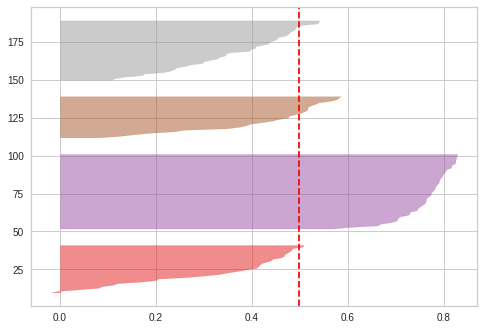

For (k= 5 ) the silhouette score is : 0.48874888709310566
Silhouette Plot:


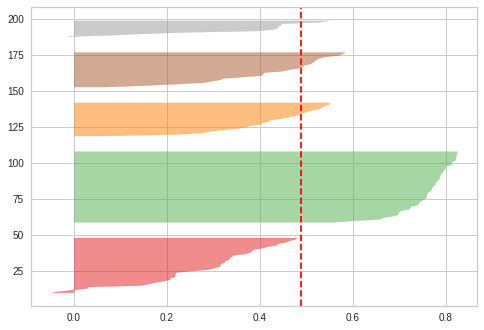

In [66]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

iris = datasets.load_iris()
X = iris.data
y = iris.target
  
for i in [2, 3, 4, 5]:

    km = KMeans(n_clusters=i)
    kmodel = km.fit(X)
    score = metrics.silhouette_score(X, kmodel.labels_, metric='euclidean')
    print("For (k=",i,") the silhouette score is :",score)
    print("Silhouette Plot:")
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(X) 
    plt.show()

Even though k=2 gives the highest Silhouette score, we can see that the thickness of the 2 clusters are not uniform.
Hence, even though k=3 has a slightly lower score, it seems like a much better 'k' value for clustering.